In [1]:
%load_ext autoreload

import sys
sys.path.append("../utils/")

# general imports
import matplotlib.pyplot as plt
%matplotlib inline

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Gate, Instruction, circuit, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
import numpy as np

import functools
import time

from quil_utils import *
from pyquil.quil import Pragma, Program
from pyquil.api import get_qc,QVM
from pyquil.gates import *
from quil_utils import Compiled_Circuit
from utils import DeviceUtils,DeviceScanner,BraketTaskScanner


import json

In [2]:
@circuit.subroutine(register=True)
def GHZ (n_qubits):
    """
    Creates a GHZ circuit with n_qubits
    
    Parameters:
    ----------------
    n_qubits : int #of qubits
    """
    out = Circuit().h([0])
    for i in range(n_qubits-1):
        out.cnot(0,i+1)

    return out
        

In [3]:
rigetti = DeviceUtils.get_device('rigetti')
ion_q = DeviceUtils.get_device('ionq')
#rigetti = LocalSimulator()
# ion_q = LocalSimulator()

#############################
Device name:  Aspen-M-2
Device type:  AwsDeviceType.QPU
Device arn:  arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-2
Device provider: Rigetti
Device status: ONLINE
Device availability:  False
Device region:  us-west-1
Supported gates:  ['cz', 'xy', 'ccnot', 'cnot', 'cphaseshift', 'cphaseshift00', 'cphaseshift01', 'cphaseshift10', 'cswap', 'h', 'i', 'iswap', 'phaseshift', 'pswap', 'rx', 'ry', 'rz', 's', 'si', 'swap', 't', 'ti', 'x', 'y', 'z', 'start_verbatim_box', 'end_verbatim_box']
a:b:c:us-west-1


{'task': 0.3, 'shot': 0.00035}

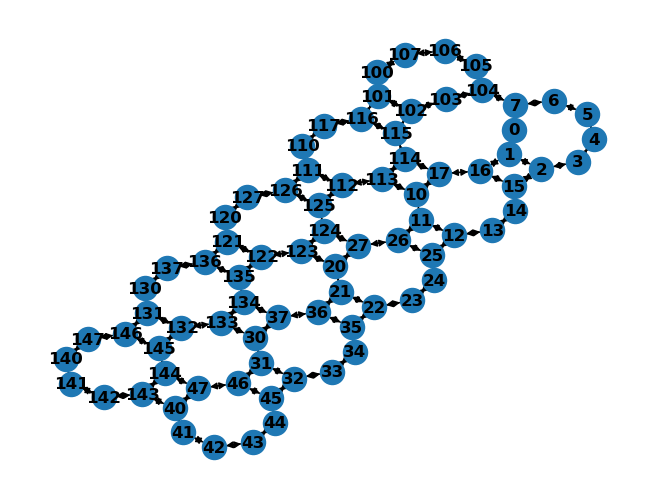

In [4]:
DeviceScanner(device=rigetti).list_properties()
DeviceScanner(device=rigetti).get_cost_infos()

#############################
Device name:  IonQ Device
Device type:  AwsDeviceType.QPU
Device arn:  arn:aws:braket:::device/qpu/ionq/ionQdevice
Device provider: IonQ
Device status: ONLINE
Device availability:  False
Device region:  
Supported gates:  ['x', 'y', 'z', 'rx', 'ry', 'rz', 'h', 'cnot', 's', 'si', 't', 'ti', 'v', 'vi', 'xx', 'yy', 'zz', 'swap']
a:b:c:us-east-1


{'task': 0.3, 'shot': 0.01}

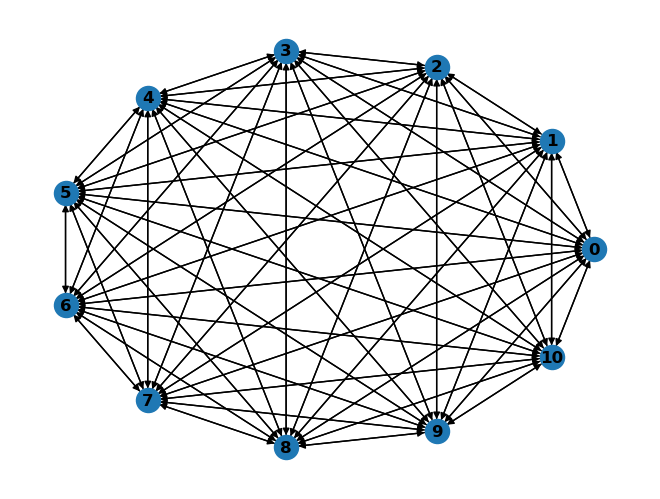

In [5]:
DeviceScanner(device=ion_q).list_properties()
DeviceScanner(device=ion_q).get_cost_infos()

## GHZ
Benchmarking QPUs with GHZ states of increasing dimensions

In [7]:
shots = 100
#set_n_qubits = range(3,10)
n_qubits_list = [2,4,6,8,10]

print(n_qubits_list)

[2, 4, 6, 8, 10]


In [8]:
id_dict = {}
rigetti_tasks = []
ionq_tasks = []
for n_qubits in n_qubits_list:
    id_dict[str(n_qubits)] = {}
    
    circ = GHZ (n_qubits)
    #print(circ)
    rigetti_task = rigetti.run(circ,shots=shots)
    ionq_task = ion_q.run(circ,shots=shots)
    rigetti_tasks.append(rigetti_task)
    ionq_tasks.append(ionq_task)
    
    id_dict[str(n_qubits)] = {'rigetti' : {'id' : rigetti_task.id},'ionq' : {'id' : ionq_task.id}}

In [9]:
with open('GHZ.json','w') as f:
    json.dump(id_dict,f,indent=3)

In [10]:
rigetti_ids = [task.id for task in rigetti_tasks]
ionq_ids = [task.id for task in ionq_tasks]


In [11]:
rigetti_task_scanners = [BraketTaskScanner(qtask=task) for task in rigetti_tasks]
ion_q_task_scanners = [BraketTaskScanner(qtask=task) for task in ionq_tasks]

In [12]:
status_rigetti = [task.get_status() for task in rigetti_task_scanners]
status_ionq = [task.get_status() for task in ion_q_task_scanners]
print(status_rigetti,status_ionq)

['QUEUED', 'QUEUED', 'QUEUED', 'QUEUED', 'QUEUED'] ['QUEUED', 'QUEUED', 'QUEUED', 'QUEUED', 'QUEUED']


In [ ]:
results_rigetti = [qtask.get_results() for qtask in rigetti_task_scanners]
ion_q_task_objects = [qtask.get_results()for qtask in ionq_scanners]

In [ ]:
def load_ids (filename):
    with open(filename,'r') as f:
        task_dict = json.load(f)
        rigetti_ids = []
        ionq_ids = []
        for key in task_dict:
            print(task_dict[key])
            task = task_dict[key]
            rigetti_ids.append(task['rigetti']['id'])
            ionq_ids.append(task['ionq']['id']) 

In [ ]:
results_rigetti = [qtask.() for qtask in rigetti_task_scanners]
ion_q_task_objects = [qtask.get_results()for qtask in ionq_scanners]